In [5]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import utils

In [6]:
from utils import Imputer, MainFeatureExtractor, SimpleStatisticsExtractor, GeoFeatureExtractor, UserFeatureExtractor
from utils import BagOfWordsExtractor, TargetEncodingExtractor, ALSEmbeddingExtractor

In [7]:
path = "data/"
data_start = pd.read_csv(path + 'train_events.csv')
video_start = pd.read_csv(path + 'video_info_v2.csv')
targets_start = pd.read_csv(path + 'train_targets.csv')
test_events = pd.read_csv(path + 'test_events.csv')
sample_submission = pd.read_csv(path + 'subm.csv')

test_events.head(), sample_submission.head()

(             event_timestamp              region ua_device_type  \
 0  2024-06-01 15:26:44+03:00  Udmurtiya Republic        desktop   
 1  2024-06-01 12:25:29+03:00    Adygeya Republic     smartphone   
 2  2024-06-01 17:23:12+03:00    Astrakhan Oblast     smartphone   
 3  2024-06-01 15:37:37+03:00  Khakasiya Republic     smartphone   
 4  2024-06-01 21:30:11+03:00              Moscow     smartphone   
 
   ua_client_type    ua_os  ua_client_name  total_watchtime rutube_video_id  \
 0        browser  Windows  Yandex Browser             2593    video_212730   
 1     mobile app  Android          Rutube              960    video_235114   
 2     mobile app  Android          Rutube             4695     video_26520   
 3        browser  Android   Chrome Mobile             2490    video_465561   
 4     mobile app  Android          Rutube             1117    video_102934   
 
    viewer_uid  
 0       22206  
 1       34531  
 2       25830  
 3       14838  
 4       13718  ,
    viewer_

In [8]:
import warnings
warnings.filterwarnings('ignore')

events, features = Imputer().fit_transform(data_start, video_start, targets_start)
test_events, test_features = Imputer().fit_transform(test_events, video_start, sample_submission)
print(test_features.shape)

for extractor in [MainFeatureExtractor(), ALSEmbeddingExtractor(), BagOfWordsExtractor(), SimpleStatisticsExtractor(), GeoFeatureExtractor(), UserFeatureExtractor()]:
    events, features = extractor.fit_transform(events, features)
    test_events, test_features = extractor.transform(test_events, test_features)
    print(test_features.shape)

features.shape, test_features.shape

Applying Imputer...
Applying Imputer...
(60004, 4)
Applying MainFeatureExtractor...
(60004, 38)
Applying ALSEmbeddingExtractor...
Applying ALSEmbeddingExtractor...
(60004, 102)
Applying BagOfWords extractor...
Applying BagOfWords extractor...
(60004, 230)
Applying SimpleStatisticsExtractor...
Applying SimpleStatisticsExtractor...
(60004, 358)
Applying GeoFeatureExtractor...
(60004, 361)
Applying UserFeatureExtractor...
(60004, 377)


((180012, 377), (60004, 377))

In [37]:
pd.set_option('display.max_columns', None)

test_features.describe()

,viewer_uid,travel_count,has_app_installed,has_other,has_android,has_windows,has_mac,has_ios,has_ipados,uses_atom,uses_samsung,uses_edge,uses_opera,uses_firefox,uses_yandex,uses_safari,uses_chrome,region_user_count_log,utc_delta,percent_fav_cat,embeds_0,embeds_1,embeds_2,embeds_3,embeds_4,embeds_5,embeds_6,embeds_7,embeds_8,embeds_9,embeds_10,embeds_11,embeds_12,embeds_13,embeds_14,embeds_15,embeds_16,embeds_17,embeds_18,embeds_19,embeds_20,embeds_21,embeds_22,embeds_23,embeds_24,embeds_25,embeds_26,embeds_27,embeds_28,embeds_29,embeds_30,embeds_31,age,sex,age_class,als_emb_0,als_emb_1,als_emb_2,als_emb_3,als_emb_4,als_emb_5,als_emb_6,als_emb_7,als_emb_8,als_emb_9,als_emb_10,als_emb_11,als_emb_12,als_emb_13,als_emb_14,als_emb_15,als_emb_16,als_emb_17,als_emb_18,als_emb_19,als_emb_20,als_emb_21,als_emb_22,als_emb_23,als_emb_24,als_emb_25,als_emb_26,als_emb_27,als_emb_28,als_emb_29,als_emb_30,als_emb_31,als_emb_32,als_emb_33,als_emb_34,als_emb_35,als_emb_36,als_emb_37,als_emb_38,als_emb_39,als_emb_40,als_emb_41,als_emb_42,als_emb_43,als_emb_44,als_emb_45,als_emb_46,als_emb_47,als_emb_48,als_emb_49,als_emb_50,als_emb_51,als_emb_52,als_emb_53,als_emb_54,als_emb_55,als_emb_56,als_emb_57,als_emb_58,als_emb_59,als_emb_60,als_emb_61,als_emb_62,als_emb_63,выпуск_count,сезон_count,серия_count,новый_count,битва_count,экстрасенс_count,часть_count,сериал_count,фильм_count,женский_count,мужской_count,финал_count,история_count,любовь_count,россия_count,обзор_count,хороший_count,невеста_count,экстра_count,выживать_count,сокровище_count,император_count,ребенок_count,дубай_count,самый_count,возвращение_count,макияж_count,титан_count,год_count,шоу_count,июнь_count,русский_count,который_count,день_count,мир_count,дом_count,смотреть_count,весь_count,это_count,vs_count,путешествие_count,свой_count,игра_count,первый_count,бесплатно_count,человек_count,сон_count,город_count,семья_count,самойлов_count,юля_count,жизнь_count,мастерская_count,топ_count,лицо_count,воля_count,образ_count,ханночка_count,язык_count,уход_count,мультфильм_count,страшный_count,аниме_count,отчаянный_count,домохозяйка_count,звезда_count,последний_count,сильный_count,вечерний_count,пацан_count,арт_count,флюид_count,тренд_count,туториал_count,почему_count,простой_count,устраивать_count,фоллаут_count,становиться_count,однажды_count,богиня_count,второй_count,черный_count,дмитрий_count,большой_count,озвучка_count,делать_count,папа_count,художник_count,косметика_count,манго_count,минута_count,рассказывать_count,сша_count,свадьба_count,se_count,секрет_count,автокресло_count,золотой_count,нато_count,концерт_count,выбирать_count,танк_count,готовить_count,распаковка_count,вести_count,матч_count,остров_count,вещь_count,класс_count,москва_count,друг_count,лето_count,монтянин_count,вопрос_count,пучок_count,ч_count,скиталец_count,поделка_count,час_count,война_count,дело_count,играть_count,эфир_count,челлендж_count,сверхъестественный_count,глаз_count,стиль_count,total_views,total_watchtime_mean,total_watchtime_max,total_watchtime_min,total_watchtime_std,total_watchtime_sum,percent_watched_mean,percent_watched_max,percent_watched_min,percent_watched_std,percent_skipped,percent_completed,percent_rewatched,duration_mean,duration_max,duration_min,duration_std,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6,category_Сериалы_viewtime,category_Сериалы_views,category_Разное_viewtime,category_Разное_views,category_Фильмы_viewtime,category_Фильмы_views,category_Хобби_viewtime,category_Хобби_views,category_Телепередачи_viewtime,category_Телепередачи_views,category_Путешествия_viewtime,category_Путешествия_views,category_Обучение_viewtime,category_Обучение_views,category_Юмор_viewtime,category_Юмор_views,category_Аниме_viewtime,category_Аниме_views,category_Интервью_viewtime,category_Интервью_views,category_Развлечения_viewtime,categ

In [9]:
test_features.head()

,viewer_uid,travel_count,has_app_installed,has_other,has_android,has_windows,has_mac,has_ios,has_ipados,uses_atom,...,category_Здоровье_viewtime,category_Здоровье_views,category_Строительство и ремонт_viewtime,category_Строительство и ремонт_views,category_Охота и рыбалка_viewtime,category_Охота и рыбалка_views,category_Дизайн_viewtime,category_Дизайн_views,category_Недвижимость_viewtime,category_Недвижимость_views
0,0,1,1,1,0,0,0,0,0,0,...,0.050628,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0,0,0,0,1,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
class CatboostEstimator:
    """
    Класс для обучения Catboost
    """

    def fit(self, X, y, ids, n_splits, cat_features, score):
        """
        Разбивает данные на k фолдов со стратификацией и обучает n_splits катбустов
        """
        self.one_model = False
        self.models = []
        scores = []
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for ind, (train_index, val_index) in enumerate(skf.split(X, y)):
            X_train = X.loc[train_index]
            y_train = y.loc[train_index]
            X_val = X.loc[val_index]
            y_val = y.loc[val_index]

            # train_idx = ids.loc[train_index]
            # train_idx.name = 'viewer_uid'

            # y_train_idx = y_train.copy()
            # y_train_idx.index = train_idx
            # X_train['viewer_uid'] = train_idx
            # val_idx = ids.loc[val_index]
            # val_idx.name = 'viewer_uid'
            # X_val['viewer_uid'] = val_idx
            # if y.name == 'age_class':
            #     target_enc_ext = utils.TargetEncodingExtractor()
            # else:
            #     target_enc_ext = utils.TargetEncodingExtractorSex()                
            # events_filtered_train = pd.merge(events, train_idx, on='viewer_uid', how='inner')
            # target_enc_ext.fit(events_filtered_train, pd.merge(X_train, y_train_idx, on='viewer_uid', how='inner'))
            # events_filtered_test = pd.merge(events, val_idx, on='viewer_uid', how='inner')

            # X_train = target_enc_ext.transform(events_filtered_train, X_train).drop(columns=['viewer_uid'])
            # X_val = target_enc_ext.transform(events_filtered_test, X_val).drop(columns=['viewer_uid'])

            model = CatBoostClassifier(cat_features=cat_features, verbose=500, iterations=1000)
            model.fit(X_train, y_train, verbose=500, eval_set=(X_val, y_val))
            
            self.models.append(model)
            y_pred = model.predict(X_val)
            scores.append(score(y_val, y_pred))
            print(f'model {ind}: score = {round(scores[-1], 4)}')
        
        scores = np.array(scores)
        print(f'mean score = {scores.mean().round(4)}, std = {scores.std().round(4)}')
        print(f'overall score = {(scores.mean() - scores.std()).round(4)}')
            
    
    def fit_select_features(self, X, y, cat_features, to_drop):
        """
        Обучает один катбуст и выполняет elect features
        """
        self.one_model = True
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        self.model = CatBoostClassifier(cat_features=cat_features, verbose=150, iterations=2000)
        
        self.model.select_features(X_train, y_train, verbose=500, eval_set=(X_val, y_val), steps=10,
                                  num_features_to_select=30, features_for_select=X.columns,
                                  algorithm='RecursiveByLossFunctionChange', train_final_model=True)

    def predict(self, X, cnt_classes):
        if self.one_model:
            return self.model.predict_proba(X)
        
        y_pred = np.zeros((X.shape[0], cnt_classes))

        for model in self.models:
            y_pred += model.predict_proba(X)
        y_pred /= cnt_classes
        y_pred = np.argmax(y_pred, axis=1)
        
        return y_pred

In [11]:
from sklearn.metrics import f1_score, accuracy_score

def score_sex(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def score_age(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

In [12]:
cat_features = []
for i, col in enumerate(features.columns):
    if features[col].dtype in ['object', 'category']:
        cat_features.append(col)
        
cat_features

['region', 'favourite_cat']

In [13]:
catboost_sex = CatboostEstimator()
catboost_age = CatboostEstimator()

features_to_drop = [
    'viewer_uid',
    'age'
]

target_sex = 'sex'
target_age = 'age_class'

print('Sex model\n')

ids = features.reset_index()['viewer_uid']
ids.name = 'viewer_uid'
y_sex = features[target_sex]
y_sex.name = target_sex

y_age = features[target_age]
y_age.name = target_age

catboost_sex.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
                 y_sex,
                 ids,
                 n_splits=2,
                 cat_features=cat_features,
                 score=score_sex)

print('\n\n\nAge model\n')

catboost_age.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
                 y_age,
                 ids,
                 n_splits=2,
                 cat_features=cat_features,
                 score=score_age)

Sex model

Learning rate set to 0.096297
0:	learn: 0.6674364	test: 0.6670821	best: 0.6670821 (0)	total: 106ms	remaining: 1m 45s
500:	learn: 0.4438258	test: 0.4891455	best: 0.4891366 (495)	total: 19.5s	remaining: 19.4s
999:	learn: 0.4031731	test: 0.4888561	best: 0.4887119 (823)	total: 38.1s	remaining: 0us

bestTest = 0.488711894
bestIteration = 823

Shrink model to first 824 iterations.
model 0: score = 0.7582
Learning rate set to 0.096297
0:	learn: 0.6665097	test: 0.6670074	best: 0.6670074 (0)	total: 55.2ms	remaining: 55.2s
500:	learn: 0.4408468	test: 0.4931839	best: 0.4931733 (498)	total: 18.9s	remaining: 18.9s
999:	learn: 0.3987584	test: 0.4927812	best: 0.4923380 (769)	total: 37.9s	remaining: 0us

bestTest = 0.4923379811
bestIteration = 769

Shrink model to first 770 iterations.
model 1: score = 0.7548
mean score = 0.7565, std = 0.0017
overall score = 0.7548



Age model

Learning rate set to 0.118144
0:	learn: 1.3433725	test: 1.3437052	best: 1.3437052 (0)	total: 161ms	remaining: 2m 

In [39]:
test_features

,viewer_uid,travel_count,has_app_installed,has_other,has_android,has_windows,has_mac,has_ios,has_ipados,uses_atom,uses_samsung,uses_edge,uses_opera,uses_firefox,uses_yandex,uses_safari,uses_chrome,region,region_user_count_log,utc_delta,favourite_cat,percent_fav_cat,embeds_0,embeds_1,embeds_2,embeds_3,embeds_4,embeds_5,embeds_6,embeds_7,embeds_8,embeds_9,embeds_10,embeds_11,embeds_12,embeds_13,embeds_14,embeds_15,embeds_16,embeds_17,embeds_18,embeds_19,embeds_20,embeds_21,embeds_22,embeds_23,embeds_24,embeds_25,embeds_26,embeds_27,embeds_28,embeds_29,embeds_30,embeds_31,age,sex,age_class,als_emb_0,als_emb_1,als_emb_2,als_emb_3,als_emb_4,als_emb_5,als_emb_6,als_emb_7,als_emb_8,als_emb_9,als_emb_10,als_emb_11,als_emb_12,als_emb_13,als_emb_14,als_emb_15,als_emb_16,als_emb_17,als_emb_18,als_emb_19,als_emb_20,als_emb_21,als_emb_22,als_emb_23,als_emb_24,als_emb_25,als_emb_26,als_emb_27,als_emb_28,als_emb_29,als_emb_30,als_emb_31,als_emb_32,als_emb_33,als_emb_34,als_emb_35,als_emb_36,als_emb_37,als_emb_38,als_emb_39,als_emb_40,als_emb_41,als_emb_42,als_emb_43,als_emb_44,als_emb_45,als_emb_46,als_emb_47,als_emb_48,als_emb_49,als_emb_50,als_emb_51,als_emb_52,als_emb_53,als_emb_54,als_emb_55,als_emb_56,als_emb_57,als_emb_58,als_emb_59,als_emb_60,als_emb_61,als_emb_62,als_emb_63,выпуск_count,сезон_count,серия_count,новый_count,битва_count,экстрасенс_count,часть_count,сериал_count,фильм_count,женский_count,мужской_count,финал_count,история_count,любовь_count,россия_count,обзор_count,хороший_count,невеста_count,экстра_count,выживать_count,сокровище_count,император_count,ребенок_count,дубай_count,самый_count,возвращение_count,макияж_count,титан_count,год_count,шоу_count,июнь_count,русский_count,который_count,день_count,мир_count,дом_count,смотреть_count,весь_count,это_count,vs_count,путешествие_count,свой_count,игра_count,первый_count,бесплатно_count,человек_count,сон_count,город_count,семья_count,самойлов_count,юля_count,жизнь_count,мастерская_count,топ_count,лицо_count,воля_count,образ_count,ханночка_count,язык_count,уход_count,мультфильм_count,страшный_count,аниме_count,отчаянный_count,домохозяйка_count,звезда_count,последний_count,сильный_count,вечерний_count,пацан_count,арт_count,флюид_count,тренд_count,туториал_count,почему_count,простой_count,устраивать_count,фоллаут_count,становиться_count,однажды_count,богиня_count,второй_count,черный_count,дмитрий_count,большой_count,озвучка_count,делать_count,папа_count,художник_count,косметика_count,манго_count,минута_count,рассказывать_count,сша_count,свадьба_count,se_count,секрет_count,автокресло_count,золотой_count,нато_count,концерт_count,выбирать_count,танк_count,готовить_count,распаковка_count,вести_count,матч_count,остров_count,вещь_count,класс_count,москва_count,друг_count,лето_count,монтянин_count,вопрос_count,пучок_count,ч_count,скиталец_count,поделка_count,час_count,война_count,дело_count,играть_count,эфир_count,челлендж_count,сверхъестественный_count,глаз_count,стиль_count,total_views,total_watchtime_mean,total_watchtime_max,total_watchtime_min,total_watchtime_std,total_watchtime_sum,percent_watched_mean,percent_watched_max,percent_watched_min,percent_watched_std,percent_skipped,percent_completed,percent_rewatched,duration_mean,duration_max,duration_min,duration_std,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6,category_Сериалы_viewtime,category_Сериалы_views,category_Разное_viewtime,category_Разное_views,category_Фильмы_viewtime,category_Фильмы_views,category_Хобби_viewtime,category_Хобби_views,category_Телепередачи_viewtime,category_Телепередачи_views,category_Путешествия_viewtime,category_Путешествия_views,category_Обучение_viewtime,category_Обучение_views,category_Юмор_viewtime,category_Юмор_views,category_Аниме_viewtime,category_Аниме_views,category_Интервью_viewtime,category_Интервью_views,category_Развл

In [32]:
age_prediction = catboost_age.predict(test_features.drop(columns=features_to_drop + [target_sex] + [target_age] + ['age']))
sex_prediction = catboost_sex.predict(test_features.drop(columns=features_to_drop + [target_sex] + [target_age] + ['age']))

sample_submission.loc[test_features.viewer_uid, 'age_class'] = age_prediction
sample_submission.loc[test_features.viewer_uid, 'sex'] = sex_prediction
sample_submission.loc[:, 'age'] = 0
sample_submission['sex'] = sample_submission['sex'].map({0: 'male', 1: 'female'})
sample_submission

,viewer_uid,age,sex,age_class
0,14416,0,male,3
1,5190,0,male,3
2,8887,0,male,1
3,55417,0,male,3
4,8980,0,male,1
...,...,...,...,...
59999,16343,0,female,1
60000,47183,0,female,3
60001,23370,0,female,2
60002,12750,0,female,1


In [33]:
sample_submission.age_class.value_counts()

age_class
1    24518
2    21508
3    13873
0      105
Name: count, dtype: int64

In [40]:
sample_submission.sex.value_counts()

sex
male      30903
female    29101
Name: count, dtype: int64

In [35]:
sample_submission.to_csv('submission.csv', index=False)

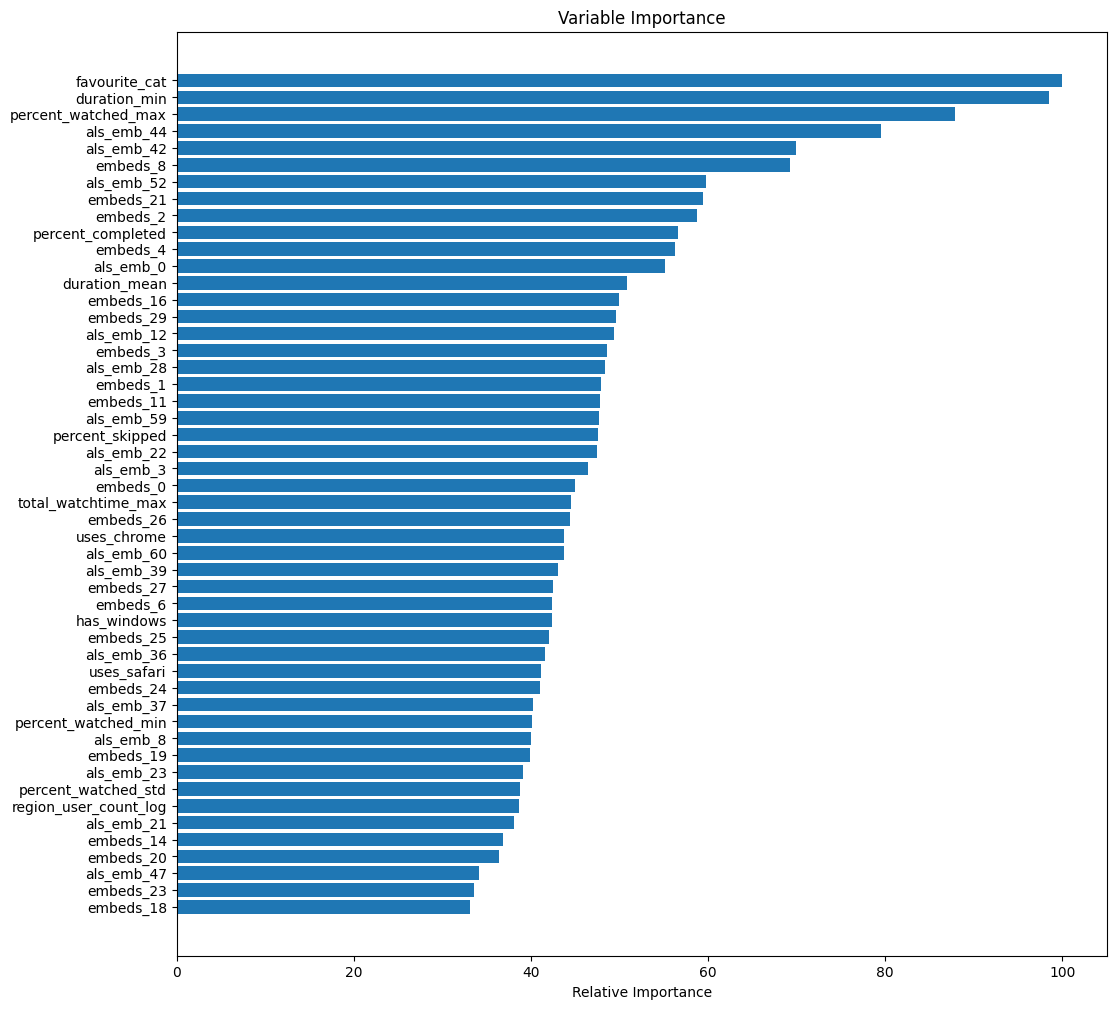

In [17]:
def plot_importance(model, features, top=50):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    cols = features.columns.to_list()
    cols = [f"target_enc_{i}" for i in range(len(sorted_idx) - len(cols))] + cols
    cols = np.array(cols)

    plt.figure(figsize=(12, 12))
    plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
    plt.yticks(pos[-top:], cols[sorted_idx][-top:])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
plot_importance(catboost_age.models[0], features.drop(columns=features_to_drop + [target_sex] + [target_age]))

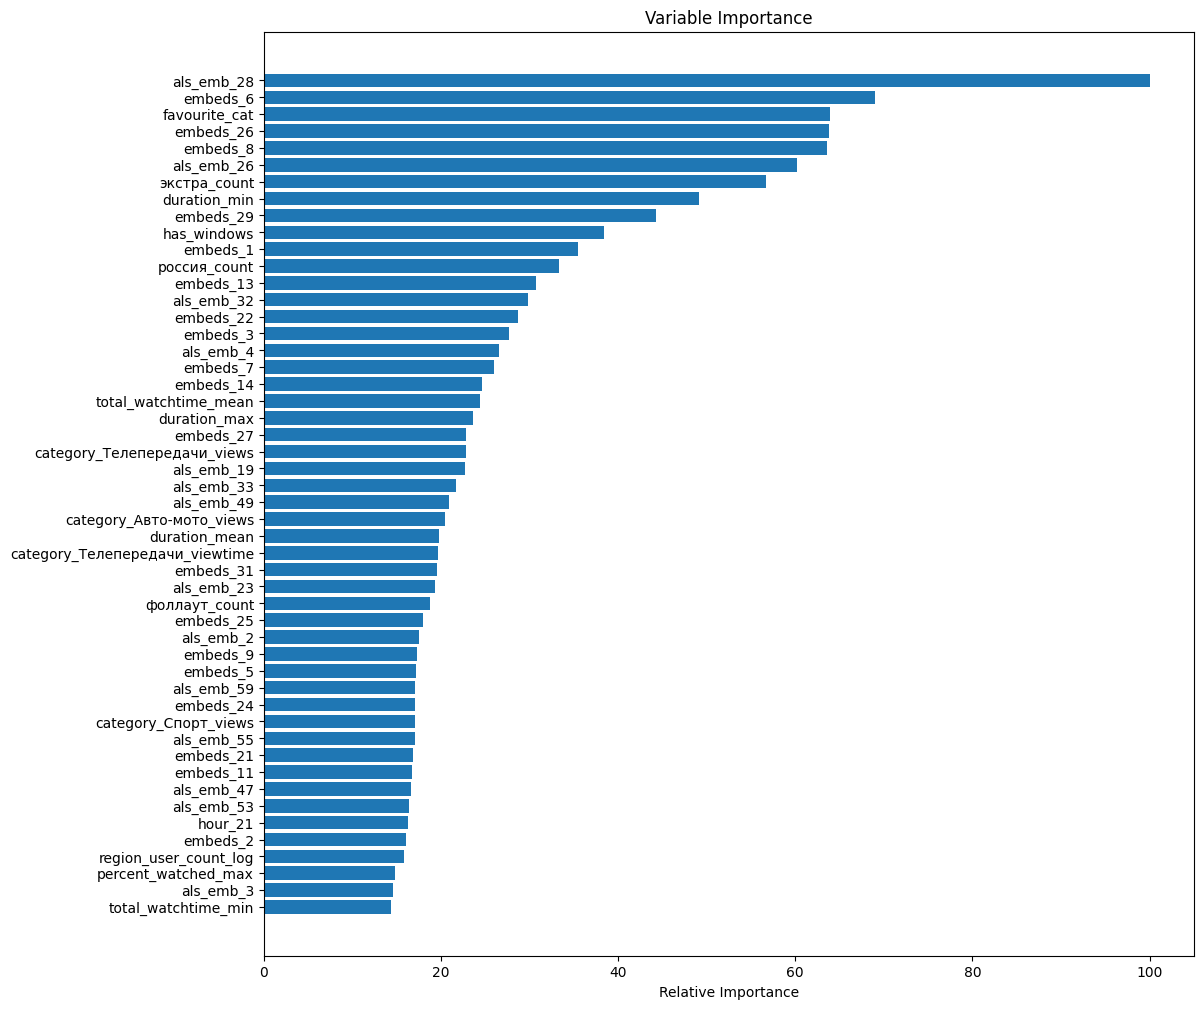

In [18]:
plot_importance(catboost_sex.models[0], features.drop(columns=features_to_drop + [target_sex] + [target_age]))